<a href="https://colab.research.google.com/github/cwerries/IANNWTF_Group_14_Submissions/blob/master/Homework_6_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [ ]:
import numpy as np

import datetime as dt

%tensorflow_version 2.x
import tensorflow as tf

import matplotlib.pyplot as plt

import os

Loading dataset Cifar-10

In [ ]:
(training_inputs, training_labels), (test_inputs, test_labels) = tf.keras.datasets.cifar10.load_data()

print("Training inputs: " + str(training_inputs.shape))
print("Training labels: " + str(training_labels.shape))
print("Test inputs: " + str(test_inputs.shape))
print("Test labels: " + str(test_labels.shape))

170508288/170498071 [==============================] - 11s 0us/step
Training inputs: (50000, 32, 32, 3)
Training labels: (50000, 1)
Test inputs: (10000, 32, 32, 3)
Test labels: (10000, 1)


In [ ]:
Input pipeline

In [ ]:
batch_size = 64

# Creates tensorflow datasets for the training and test data.
training_dataset = tf.data.Dataset.from_tensor_slices((training_inputs, training_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels))

# Conducts the normalization of the inputs (images) and the one-hot-encoding of the targets.
training_dataset = training_dataset.map(lambda inp, tar: (inp, tf.one_hot(tf.squeeze(tar), 10)))
# tf.squeeze(tar) to remove dimensions of size 1 from the shape of the target-tensors.
training_dataset = training_dataset.map(lambda inp, tar: ((2*(inp/255)-1), tar))

# Conducts the normalization of the inputs (images) and the one-hot-encoding of the targets.
test_dataset = test_dataset.map(lambda inp, tar: (inp, tf.one_hot(tf.squeeze(tar), 10)))
# tf.squeeze(tar) to remove dimensions of size 1 from the shape of the target-tensors.
test_dataset = test_dataset.map(lambda inp, tar: ((2*(inp/255)-1), tar))
                                                                                          
# Batches, shuffles and prefetches the training- and test datasets.
training_dataset = training_dataset.batch(batch_size)
training_dataset = training_dataset.shuffle(buffer_size = batch_size*10)
training_dataset = training_dataset.prefetch(batch_size)

test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size = batch_size*10)
test_dataset = test_dataset.prefetch(128)

In [ ]:
Transition layer

In [ ]:
# Description: Instantiates the layers and computations involved in a TransitionLayer from DenseNet
#              A transition layer is used to reduce the number of channels and control complexity of model
class TransitionLayer(tf.keras.layers.Layer): 
  
  def __init__(self, num_channels_trans_layer):
    super(TransitionLayer, self).__init__()

    self.conv_1 = tf.keras.layers.Conv2D(filters = num_channels_trans_layer,
                                         kernel_size = 1,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   
                                         bias_initializer = 'zeros',                                 
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))
            
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()

    self.activ_1 = tf.keras.activations.relu
                             
    self.aver_pool_1 = tf.keras.layers.AveragePooling2D(strides=(2, 2), padding = 'same')   #Without strides?

  @tf.function
  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.batch_norm_1(x, training)
    x = self.activ_1(x)
    x = self.aver_pool_1(x)
    return x

In [ ]:
#Description: Class creates a convolutional block wich for the Dense Blocks.
#             concatenation of input and output of each convolution block
class ConvolutionalBlock(tf.keras.layers.Layer): 
  
  def __init__(self, num_filter):
    super(ConvolutionalBlock, self).__init__()

    self.batch_norm_1 = tf.keras.layers.BatchNormalization()

    self.activ_1 = tf.keras.activations.relu

    self.conv_1 = tf.keras.layers.Conv2D(filters = num_filter,
                                         kernel_size = 1,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   
                                         bias_initializer = 'zeros',                                 
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))
            
    self.conv_2 = tf.keras.layers.Conv2D(filters = num_filter,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   
                                         bias_initializer = 'zeros',                                 
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))
            
    self.batch_norm_2 = tf.keras.layers.BatchNormalization()

    self.activ_2 = tf.keras.activations.relu

    self.dropout = tf.keras.layers.Dropout(rate = 0.1)
              
    self.concat = tf.keras.layers.Concatenate()               

  @tf.function
  def call(self, block_input, training = True):
    x = self.batch_norm_1(block_input, training)
    x = self.activ_1(x)
    x = self.conv_1(x)
    x = self.conv_2(x) 
    x = self.batch_norm_2(x, training)
    x = self.activ_2(x)
    x = self.dropout(x, training)
    # Concatenate the input and output of each block
    block_output = self.concat([x, block_input]) 
    return block_output

In [ ]:
#Description: Dense Block consists of multiple convolutional blocks.      
class DenseBlock(tf.keras.layers.Layer): 

  def __init__(self, list_num_filter):
    super(DenseBlock, self).__init__()

    self.convolutional_blocks = []
    for num_filter in list_num_filter:
      self.convolutional_blocks.append(ConvolutionalBlock(num_filter))

  @tf.function
  def call(self, x, training = True):
    for conv_block in self.convolutional_blocks:
      x = conv_block(x, training)
    return x

In [ ]:
#Description: Dense net class consits of alternating Dense Blocks and transitional layers
#             Concatenates inputs and outputs.
class DenseNet(tf.keras.Model): 
  
  def __init__(self, num_dense_blocks, list_num_filter, growth_rate):
    super(DenseNet, self).__init__()
    num_conv_blocks = len(list_num_filter)
    # Feature extractor
    self.conv_1 = tf.keras.layers.Conv2D(filters = 32,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   
                                         bias_initializer = 'zeros',                                 
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01),        
                                         input_shape = (32, 32, 3))
    
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()

    self.activ_1 = tf.keras.activations.relu

    self.dropout_1 = tf.keras.layers.Dropout(rate = 0.6)    

    # calculöate channel size for transitional layer
    num_channels_trans_layer = growth_rate * num_conv_blocks

    self.dense_blocks_and_trans_layers = []

    # The last dense block does not need a transition layer -> num_dense_blocks - 1 
    for _ in range(num_dense_blocks - 1):                         
      self.dense_blocks_and_trans_layers.append(DenseBlock(list_num_filter))   
      self.dense_blocks_and_trans_layers.append(TransitionLayer(num_channels_trans_layer))

    self.last_dense_block = DenseBlock(list_num_filter)

    # Classifier to produce the output
    self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
    self.dropout_2 = tf.keras.layers.Dropout(rate = 0.6)                                                  
    self.output_layer = tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)


  @tf.function
  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.batch_norm_1(x, training)
    x = self.activ_1(x)
    x = self.dropout_1(x, training)

    for i in self.dense_blocks_and_trans_layers:
      x = i(x, training)
    x = self.last_dense_block(x, training)

    x = self.global_pool(x)
    x = self.dropout_2(x, training)
    x = self.output_layer(x)
    return x

Training and testing function

In [ ]:
#@tf.function
def training_step(model, training_data, loss_fn, optimizer, training = True):
  training_losses = []
  training_accuracies = []

  for (input, target) in training_data:
    with tf.GradientTape() as tape:
      prediction = model(input, training)
      current_training_loss = loss_fn(target, prediction)+ tf.math.reduce_sum(model.losses)   
      gradients = tape.gradient(current_training_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    training_losses.append(current_training_loss.numpy())

    current_training_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    training_accuracies.append(np.mean(current_training_accuracy))  
  
  training_loss = np.mean(training_losses)
  training_accuracy = np.mean(training_accuracies)
  return training_loss, training_accuracy

#@tf.function
def test(model, test_data, loss_fn, training = False):
  test_losses = []
  test_accuracies = []

  for (input, target) in test_data:
    prediction = model(input, training)
    
    current_test_loss = loss_fn(target, prediction)
    test_losses.append(current_test_loss.numpy())

    current_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    test_accuracies.append(np.mean(current_test_accuracy))   
    
  test_loss = np.mean(test_losses)
  test_accuracy = np.mean(test_accuracies)
  return test_loss, test_accuracy

Training the network

In [ ]:
tf.keras.backend.clear_session()

num_dense_blocks = 3
list_num_filter =[64, 32, 32, 16, 8]
num_conv_blocks = len(list_num_filter)
growth_rate = 40
model = DenseNet(num_dense_blocks, list_num_filter, growth_rate)   

n_epochs = 10
learning_rate = 0.0005
loss_fn = tf.keras.losses.CategoricalCrossentropy()                    # CategoricalCrossentropy because of 10 labels to differ.
optimizer = tf.keras.optimizers.Adam(learning_rate, amsgrad = True)    # Optimizer Adam (Adaptive Moment Estimation) with AMSGrad activated.
 


training_losses = []
training_accuracies = []
test_losses = []
test_accuracies = []

dynamic_threshold_train_visio = 0.5                                    # Test accuracy threshold from which the training progress is displayed.
# Training and test loop
for epoch in range(n_epochs):
    print('Epoch ' + str(epoch))
    ts_now = dt.datetime.now()
    print(ts_now)

    training_loss, training_accuracy = training_step(model, training_dataset, loss_fn, optimizer, training = True)
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)

    test_loss, test_accuracy = test(model, test_dataset, loss_fn, training = False)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print("Training accuracy: " + str(training_accuracy))
    print("Test accuracy: " + str(test_accuracy))


Epoch 0
2021-12-04 09:01:38.680018
Training accuracy: 0.40746882992327366
Test accuracy: 0.29866640127388533
Epoch 1
2021-12-04 09:05:20.009680
Training accuracy: 0.5536285166240409
Test accuracy: 0.2005374203821656
Epoch 2
2021-12-04 09:08:38.986380
Training accuracy: 0.5973665281329923
Test accuracy: 0.5147292993630573
Epoch 3
2021-12-04 09:11:57.244804
Training accuracy: 0.6245604219948849
Test accuracy: 0.37350716560509556
Epoch 4
2021-12-04 09:15:15.094476
Training accuracy: 0.648996962915601
Test accuracy: 0.585390127388535
Epoch 5
2021-12-04 09:18:32.181143
Training accuracy: 0.6619645140664961
Test accuracy: 0.49263535031847133
Epoch 6
2021-12-04 09:21:49.631582
Training accuracy: 0.6792079603580563
Test accuracy: 0.5034832802547771
Epoch 7
2021-12-04 09:25:06.022775
Training accuracy: 0.6937939578005116
Test accuracy: 0.5411027070063694
Epoch 8
2021-12-04 09:28:22.672989
Training accuracy: 0.7019261508951407
Test accuracy: 0.6894904458598726
Epoch 9
2021-12-04 09:31:38.383077


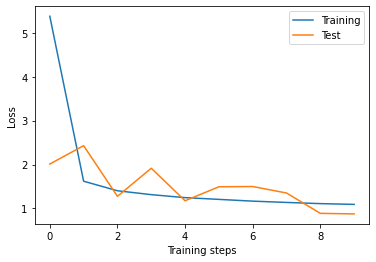

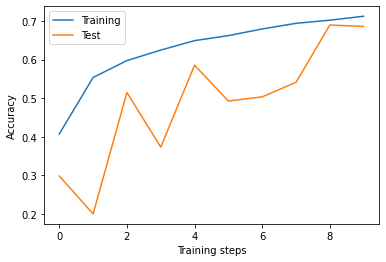

In [ ]:
plt.figure()
line1, = plt.plot(training_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1, line2),("Training", "Test"))
plt.show()

plt.figure()
line1, = plt.plot(training_accuracies)
line2, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.legend((line1, line2),("Training", "Test"))
plt.show()